<a href="https://colab.research.google.com/github/JMQuinlan/Boundary-Layer/blob/main/Blasius_shooting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Integrate (solve) the Blasius Equation with the shooting method

copyright 2021 - J. M. Quinlan  
University of Colorado  
Colorado Springs  

In this notebook we integrate the Blasius Equation for boundary layer flow over a flat plat treating the BVP as a IVP.

The Navier-Stokes equations reduce to the nondimensional Boundary Layer Equations for high-Reynolds numbers:
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y}  = 0 $$  

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} =  \underbrace{U_e \frac{\partial U_e}{\partial x}}_{\textstyle -~ \dfrac{\mathrm{d} p}{\mathrm{d} x}}
      +   \frac{1}{\mathrm{Re}} \frac{\partial^2 u}{\partial y^2}$$

Where the pressure gradient (or exterior flow $U_e$) is prescribed--imposed on the boundary layer.

For the flat plate aligned with a steady, uniform flow the pressure gradient must be zero.
Further, assuming the outer, potential flow is steady yields:

$$ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} =  \frac{1}{\mathrm{Re}} \frac{\partial^2 u}{\partial y^2}$$

Defining a similarity variable:

$$\eta \equiv \frac{y}{\sqrt{x}} =\frac{y^*}{\sqrt{\dfrac{\nu^*\,x^*}{U_\infty^*}}} =y^*\sqrt{\frac{U_\infty^*}{\nu^*\,x^*}}$$

And a nondimensional streamfunction as:

$$f(\eta) \equiv \frac{\Psi^*}{\nu^*\, x^*\, U_\infty^*}$$

The governing equation (Continuity satisfied automatically by the streamfunction) is:

$$ f''' + \frac{1}{2} f\,f'' = 0 $$

Where the primes represent the derivative with respect to $\eta$.

And boundary conditions:
$$f(\eta=0) = 0 $$
$$   f'(\eta = 0) = 0 $$
$$   f'(\eta \rightarrow \infty) \rightarrow 1 $$  

This third-order ODE problem is a BVP, but we can integrate it like an IVP by iterating on a fictitious initial value for $f''(0)$ and checking to see if the solution matches the final boundary condition.
___

Note that this is not intended to be instructive for how you would code this to solve for these values, for instance using a random walk root finder to find the correct value of $f''(0)$.
Quite the opposite, the code forces you to do the iteration by hand but give you all of the pieces in very few lines of code.

Let's get started.

Import required libraries:

In [ ]:
import numpy as np
from scipy import integrate
from matplotlib.pylab import plt
import matplotlib as mpl

Here we setup the known initial conditions at $\eta = 0$: $f(0) = 0$ and $f'(0) = 0$.
Then we also guess the ``initial condition'' for $f''(0)$, and iterate to get $f'(\eta \rightarrow \infty) \rightarrow 1$.

To start, pick a value for:
```
u[2]
```
and iterate.

In [ ]:
# Order of problem
mx = 3

# Define system parameters
u = np.zeros((mx,1),dtype=complex) # Initial values for generalized coordinates (for this problem there is no need for this to be complex)
u[0] = 0.
u[1] = 0.
u[2] = 0.3320594

# Plotting stuff
color1 = color=(0,0,0.6)
color2 = color=(1,0,0)
color3 = color=(0.2,1,0.2)
fnmul = 2
figdim = (3.25*fnmul,2.5*fnmul)
# mpl.rc('text', usetex = True) # set if you want to use TeX for plot text
mpl.rc('text', usetex = False) # Faster than TeX and only need extra 'r' as in: r'$ \alpha $'

Define the system of first-order differential equations as a Python function (input $u$ and return $u'$):

In [ ]:
# define system to be solved: du/dt = f(u,t)
def sysde(t, u):
    """
    Simple spring-mass-damper system - 2 DOF

    f     = u[0] = Nondim. streamfunction
    f'    = u[1] = Nondim. x-direction velocity
    f''   = u[2] = Related to velocity gradient and hence the shear stress at the wall 
    f'''  = u[3] = Related to velocity curvature (comes from viscous term)

    Returns 
    du/dt=[    u[1]          ]
          [    u[2]          ]
          [-1./2.*u[0] * u[2]]
    """

    # Assign some variables for convenience of notation
    # f         = u[0]
    # f'   = G  = u[1]
    # f''  = H  = u[2]
    # f''' = H' = u[3]

    # Output from ODE function must be a COLUMN vector, with n rows
    n = len(u)
    dudt = np.zeros((n,1),dtype=complex)
    dudt[0] = u[1]
    dudt[1] = u[2]
    dudt[2] = -1./2.*u[0]*u[2]
    
    return dudt

Perform the integration and plot:

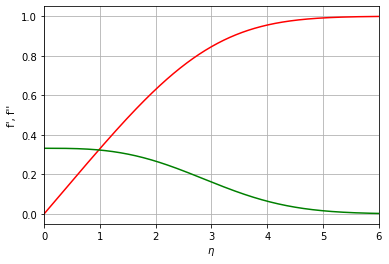

In [ ]:
# Start by specifying the integrator:
# use ``vode`` with "backward differentiation formula"
r = integrate.ode(sysde).set_integrator('zvode', method='bdf')

# Set the time range (inthis case eta is acting as the time variable)
t_start = 0.0
t_final = 25.0
delta_t = 0.01
# Number of time steps: 1 extra for initial condition
num_steps = int(np.floor((t_final - t_start)/delta_t) + 1)

# Set initial condition(s): for integrating variable and time
r.set_initial_value(u, t_start)

# Additional Python step: create vectors to store trajectories
t = np.zeros((num_steps, 1))
f0 = np.zeros((num_steps, 1),dtype=complex)
f1 = np.zeros((num_steps, 1),dtype=complex)
f2 = np.zeros((num_steps, 1),dtype=complex)
data = np.zeros((mx,num_steps)) # Initial values for generalized coordinates
t[0] = t_start
f0[0] = u[0]
f1[0] = u[1]
f2[0] = u[2]
data[:,0] = u.real.T

# Integrate the ODE(s) across each delta_t timestep
kk = 1
while r.successful() and kk < num_steps:
    r.integrate(r.t + delta_t)

    # Store the results to plot later
    t[kk] = r.t
    f0[kk] = r.y[0]
    f1[kk] = r.y[1]
    f2[kk] = r.y[2]
    data[:,kk] = r.y.real.T
    kk += 1

# Plot the trajectories in two separate plots:
fig = plt.figure(22)
ax1 = plt.subplot(111)
# ax1.plot(t, f0.real, 'b')
ax1.plot(t, f1.real, 'r')
ax1.plot(t, f2.real, 'g')
ax1.set_xlim(t_start, 6.)
ax1.set_xlabel(r'$\eta$')
ax1.set_ylabel(" f', f'' ")
ax1.grid('on')

# Save figure
fig.savefig('Blasius.eps')
fig.savefig('Blasius.pdf')
# Show figure
plt.show()
plt.close()

Does the IVP produce the value requied to meet the BVP?
In other words, does $f'(\eta \rightarrow \infty) \rightarrow 1$?

In [ ]:
print(f1[-1])

[1.00000001+0.j]


Let's define the boundary layer thickness as the distance from the wall to the point at which the velocity reaches 99\% of the free-stream velocity.

Find the index for which $f' = 0.99$ and print the value of $\eta_{\,0.99} = 4.91 \approx 5$.

In [ ]:
print(f1[491])
print(t[491])

[0.99000024+0.j]
[4.91]


As a result of our theory and numerical simulation we see that the boundary layer thickness grows as:
$$ \delta \equiv \frac{\delta^*}{x^*} = \frac{5}{\sqrt{\mathrm{Re,_x}}~} $$

___
A few measures that you could now calulate are (in terms of nondimensional and dimensional quantities):  

$v_e$: the $y$-direction velocity at the edge of the boundary layer ($\ne 0$, due to displacment effects)

$\tau_w$: the shear stress at the wall

$\delta_1$: the displacment thickness

$\delta_2$: the momentum thickness

$\frac{\delta_1}{\delta}$: body shape change

$\frac{\delta_2}{\delta}$: relitive thicness of the momentum thickness and the boundary layer thickness (note that this is $<< 1$)

